# Imports and Functions

In [1]:
import math 
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.backend_bases import MouseButton
import matplotlib.path as path
from matplotlib.colors import ListedColormap
import numpy as np
from numpy import load
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.neighbors import KDTree
%matplotlib notebook

global selection_model

import random
from random import randint

global cm
global cm_bright
global wales
global maxiter
global numcoords
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

wales = load('walesoutline1.npy')
wales = path.Path(wales)


maxiter = 21
numcoords = 2
selection_model = 4 #0 for 0.5, 1 for isolated, 2 for random, 3 for best, 4 for sim_anneal

global threshold
threshold = 20 

In [2]:
import math
def normpdf(x, mean, sd):
    var = float(sd)**2
    denom = (2*math.pi*var)**.5
    num = math.exp(-(float(x)-float(mean))**2/(2*var))
    return num/denom

In [3]:
def calculateModel():
    
    global X
    global Z
    global Z_model_pred
    global Znew
    global Zbranin
    global xx,yy
    global Big_df
    global Big_df_land
    global clf


    x_min, x_max = -5, 51 
    y_min, y_max = -2, 53
    h = .5  # step size in the mesh

    Coords_df = pd.DataFrame(coords,columns=['XPos','YPos','Type'])
    DT_X_Values = Coords_df.drop(['Type'],axis=1)

    X = DT_X_Values.to_numpy().tolist()
    X = np.array(X)

    DT_Y_Values = Coords_df.drop(['XPos'],axis=1)
    DT_Y_Values = DT_Y_Values.drop(['YPos'],axis=1)
    y = DT_Y_Values.to_numpy().ravel()



    clf = ExtraTreesClassifier(n_estimators = 100)
    clf.fit(X, y)
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
    
    Zbranin = []
    branincoords = np.c_[xx.ravel(), yy.ravel()]
    for i in range(12320):
        Zbranin.append(braninColor(branincoords[i],threshold))



    Z_model_prob = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z_model_prob = Z_model_prob.reshape(xx.shape)                                                      #Z is [model_probs]
    Z_model_pred = clf.predict(np.c_[xx.ravel(), yy.ravel()])[:]                        #Z_model_pred is [model_predictions]

    Big_df = pd.DataFrame(xx.ravel(), columns=['xx'])#
    Big_df.insert(1, 'yy',yy.ravel())
    Big_df.insert(2, 'Z_model_predictions', Z_model_pred.ravel())
    Big_df.insert(3, 'Z_model_predictions_flattened', 0)
    Big_df.insert(4, 'Z_model_probs', Z_model_prob.ravel())
    Big_df.insert(5, 'Z_model_probs_flattened_SEA', 0)
    Big_df.insert(6, 'Z_model_probs_flattened_0', 0)
    Big_df.insert(7, 'Surrogate_model_predictions', Zbranin)
    Big_df.insert(8, 'Surrogate_model_predictions_flattened', 0)

    for i in range(12320):

        if (wales.contains_points([(Big_df.iat[i,0],Big_df.iat[i,1])])[0]):
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = Big_df.iloc[i]['Z_model_probs']
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = Big_df.iloc[i]['Surrogate_model_predictions']
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = Big_df.iloc[i]['Z_model_probs']

        else:
            Big_df.loc[i, 'Z_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_SEA'] = 'SEA'
            Big_df.loc[i, 'Surrogate_model_predictions_flattened'] = 'SEA'
            Big_df.loc[i, 'Z_model_probs_flattened_0'] = 0

    Z_model_predictions = Big_df["Z_model_predictions"].to_numpy()
    Z_model_predictions_flattened = Big_df["Z_model_predictions_flattened"].to_numpy()
    Z_model_probs = Big_df["Z_model_probs"].to_numpy()
#     Z_model_probs_flattened = Big_df["Z_model_probs_flattened"].to_numpy()
    Surrogate_model_predictions = Big_df["Surrogate_model_predictions"].to_numpy()
    Surrogate_model_predictions_flattened = Big_df["Surrogate_model_predictions_flattened"].to_numpy()

    Big_df_land = Big_df[Big_df['Z_model_predictions_flattened'] != 'SEA']

    Contour_model = Big_df["Z_model_probs_flattened_0"].to_numpy()
    Contour_model = Contour_model.reshape(xx.shape) 


    plt.cla()
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic_r')
    # plt.axis("off")
    plt.grid()
    ax.contourf(xx, yy, Contour_model, 40, cmap=cm, alpha=
                0.4)

    plt.plot()

    plt.show()


In [4]:
def StaticPen(x):

    if(wales.contains_point(x)):
        pen = 1
    else:
        pen = 0

    dist = (tree.query([x], k=1)[0])
    prob = clf.predict_proba([x])[0][0]
    tmp_score = (0.5-np.abs(0.5-prob))*dist

    return dist*pen

def sim_anneal_iso():
    
    global tree
    
    tree = KDTree(X, leaf_size=40)

    lower_bound = np.array([-5,-2])
    upper_bound = np.array([51,53])
    max_iter = 1000
    stdevscale = 0.2*(upper_bound-lower_bound)
    gamma = 0.35
    t_initial = 1000
    r = 100
    beta = 1

    import math
    from scipy.stats import truncnorm
    global Xdash,Ydash




    Xbest = np.random.uniform(low  = lower_bound,    
                          high = upper_bound,        
                          size = (len(lower_bound)))

    Ybest = StaticPen(Xbest)
    Xcenter = Xbest                                          
    Ycenter = Ybest
    t_k=t_initial

    for k in range(max_iter-1):  

        Xdash = truncnorm.rvs((lower_bound - Xcenter)/stdevscale,(upper_bound-Xcenter)    
                              /stdevscale,loc=Xcenter,scale=stdevscale)          

        Ydash = StaticPen(Xdash)
        deltaY = Ydash - Ycenter

        if deltaY<=0 or np.random.rand()<min((math.exp(-deltaY/t_k)),1):
            Xcenter = Xdash
            Ycenter = Ydash                               

            if Ydash>Ybest:
                Xbest=Xdash
                Ybest=Ydash

                t_k = t_k*gamma    

    ax.scatter(Xbest[0],Xbest[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
    print('sim_anneal_isolated coord:',(Xbest[0],Xbest[1]),'distance:',Ybest)
    
    return np.array([Xbest[0],Xbest[1]])

In [5]:
def find_isolated_point():
       
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]

    testpoints = tmp_df[['xx','yy']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        if dist>maxdist:
            maxdist = dist
            maxind = ind
            ifinal = i

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)
    plt.plot()
    plt.show()
    fig1.show()
#     print('isolated', testpoints[ifinal])
    return testpoints[ifinal]
    
def find0_5():
    
    tmp_df = Big_df.iloc[(Big_df['Z_model_probs_flattened_0']-0.50).abs().argsort()[:2]]
    value = randint(0, len(tmp_df.index)-1)
    uncertain_coord = [tmp_df.iloc[value]['xx'],tmp_df.iloc[value]['yy']]
        
    ax.scatter(uncertain_coord[0], uncertain_coord[1], c='#00FF00', s=25)
    plt.plot()
    plt.show()    
    fig1.show()
      
#     print('0_5', uncertain_coord)
    return uncertain_coord

def random_point():
    
    tmp_df = Big_df_land.iloc[:, :]
    testpoints = tmp_df[['xx','yy']].to_numpy()
                    
    ifinal = randint(0,len(testpoints.tolist()))
    
    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()
    
    fig1.show()
    
    return testpoints[ifinal]

def best():
    
    tree = KDTree(X, leaf_size=40)
    maxdist = 0
    maxind = -1
    ifinal = -1
    tmp_df = Big_df_land.iloc[::5, :]
    score = 0

    testpoints = tmp_df[['xx','yy']].to_numpy()
    testpoints1 = tmp_df[['Z_model_probs']].to_numpy()

    for i in range(len(testpoints)):
        dist, ind = tree.query([testpoints.tolist()[i]], k=1)
        prob = testpoints1[i]
        tmp_score = dist*normpdf(prob,0.5,0.05)
        if tmp_score>score:
            ifinal = i
            distfinal = dist
            probfinal = prob
            score = tmp_score

    ax.scatter(testpoints[ifinal][0], testpoints[ifinal][1], c='#00FF00', s=25)

    plt.plot()

    plt.show()

    fig1.show()
    
    find0_5()
    find_isolated_point()
    
    print(distfinal)
    print(probfinal)
    print(score)
    print('best',testpoints[ifinal])

    return testpoints[ifinal]
    
    



In [6]:
def Accuracy():
    
    correctPredictions = 0
    incorrectPredictions = 0

    for i in range(len(Big_df_land.index)):
        if ((Big_df_land.iloc[i]["Z_model_predictions"])==(Big_df_land.iloc[i]["Surrogate_model_predictions"])):
            correctPredictions+=1
        else:
            incorrectPredictions+=1


    accuracy = (correctPredictions)/((
    incorrectPredictions+correctPredictions))
    accuracyArray.append(accuracy)

    print('Accuracy is',accuracy)
    

def printGraph():
    
    xAxis = []
    for i in range(len(accuracyArray)):
        xAxis.append(i+1)

    plt.scatter(xAxis, accuracyArray) 
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy over time')
    plt.ylim(0.3, 1.0)  
    plt.show()

In [7]:
def xnew(x): 
    return (-5)+(((x+5)*(10+5))/(51+5))
def ynew(y): 
    return ((y+2)*(15))/(55)

def branin(x, a=1, b=5.1/(4*(np.pi**2)), c=5/np.pi, r=6, s=10, t=1/(8*np.pi), noise=0.1):
       
    return a*(x[1]-(b*(x[0]**2))+c*x[0]-r)**2+(s*(1-t)*np.cos(x[0]))+s

def braninColor(x, threshold):
    
    if branin((xnew(x[0]),xnew(x[1])))>threshold:
        return 1
    else:
        return 0

# Plot first graph

experiment:  0


<IPython.core.display.Javascript object>


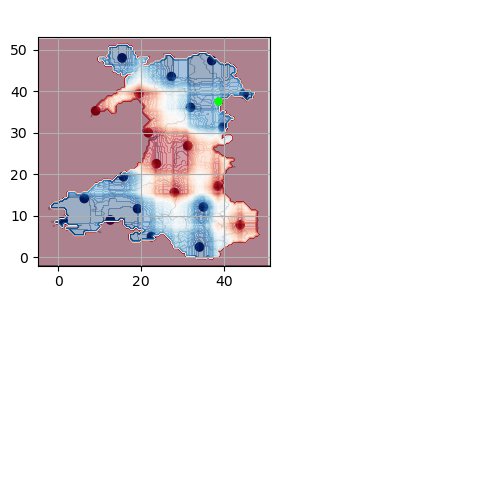

iteration  1
Accuracy is 0.49009805806575657
sim_anneal_isolated coord: (1.159430223071512, 8.842044874712006) distance: [[35.04633837]]
iteration  2
Accuracy is 0.6123822341857336
sim_anneal_isolated coord: (43.79768076724442, 7.828735142976727) distance: [[22.84600908]]
iteration  3
Accuracy is 0.6227648529129014
sim_anneal_isolated coord: (22.448626194007787, 4.988039559725175) distance: [[21.53721622]]
iteration  4
Accuracy is 0.608536819842338
sim_anneal_isolated coord: (15.701691892368467, 19.45425443008753) distance: [[15.96222087]]
iteration  5
Accuracy is 0.5821957315900789
sim_anneal_isolated coord: (44.740367837037454, 39.34710048092467) distance: [[17.99692047]]
iteration  6
Accuracy is 0.6425687367813882
sim_anneal_isolated coord: (9.009553957282858, 35.30544456925641) distance: [[17.2059565]]
iteration  7
Accuracy is 0.6754470294174197
sim_anneal_isolated coord: (27.940106069933258, 15.632194942071704) distance: [[11.71978049]]
iteration  8
Accuracy is 0.7265910401845799


<IPython.core.display.Javascript object>


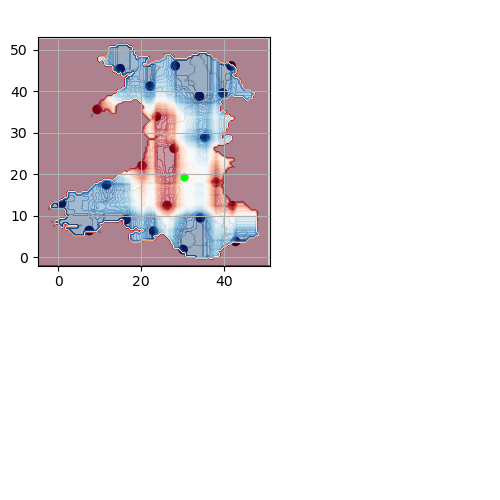

iteration  1
Accuracy is 0.47894635646990963
sim_anneal_isolated coord: (14.89859100969498, 45.449122306089855) distance: [[42.67388039]]
iteration  2
Accuracy is 0.588925206691021
sim_anneal_isolated coord: (0.7483980448493304, 12.936401198650689) distance: [[31.33441161]]
iteration  3
Accuracy is 0.5912324552970583
sim_anneal_isolated coord: (41.633990115898285, 46.11636012665317) distance: [[26.74372397]]
iteration  4
Accuracy is 0.6275716208421458
sim_anneal_isolated coord: (20.2126995634719, 22.111095960253298) distance: [[21.51822617]]
iteration  5
Accuracy is 0.7694674101134398
sim_anneal_isolated coord: (35.33016265139506, 28.92386005862517) distance: [[16.5816599]]
iteration  6
Accuracy is 0.6791001730436454
sim_anneal_isolated coord: (16.350980972403033, 9.12360199462546) distance: [[13.54946014]]
iteration  7
Accuracy is 0.7269755816189194
sim_anneal_isolated coord: (28.169131230292795, 46.15098913651064) distance: [[13.28908781]]
iteration  8
Accuracy is 0.6964045375889252


<IPython.core.display.Javascript object>


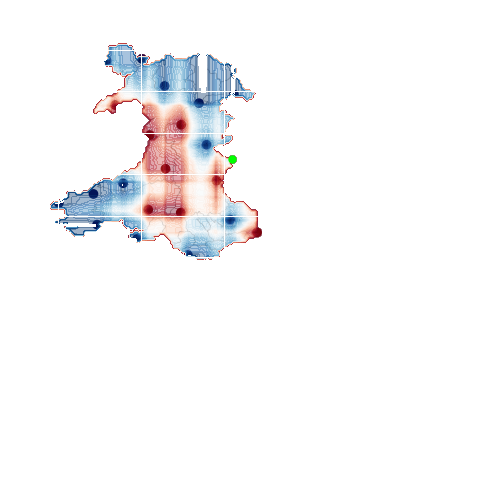

iteration  1
Accuracy is 0.48125360507594694
sim_anneal_isolated coord: (25.620224744476637, 41.28483035141452) distance: [[30.75340852]]
iteration  2
Accuracy is 0.6556431455489329
sim_anneal_isolated coord: (0.1415794763799023, 13.06370817155166) distance: [[29.45231601]]
iteration  3
Accuracy is 0.690636416073832
sim_anneal_isolated coord: (35.73178143750395, 27.144127777782014) distance: [[17.38398827]]
iteration  4
Accuracy is 0.6439146318015766
sim_anneal_isolated coord: (15.620069866380122, 17.85659033309268) distance: [[15.58532259]]
iteration  5
Accuracy is 0.6496827533166699
sim_anneal_isolated coord: (42.291777273763714, 39.240599837837756) distance: [[13.76074786]]
iteration  6
Accuracy is 0.6512209190540281
sim_anneal_isolated coord: (11.640011246121933, 47.383519061094695) distance: [[15.25255301]]
iteration  7
Accuracy is 0.6610267256296866
sim_anneal_isolated coord: (22.048466389010358, 29.451146188342896) distance: [[12.36096835]]
iteration  8
Accuracy is 0.69717362045

<IPython.core.display.Javascript object>


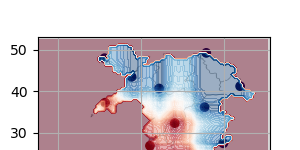

iteration  1
Accuracy is 0.4845222072678331
sim_anneal_isolated coord: (35.64441044006879, 49.258523311527085) distance: [[41.26376794]]
iteration  2
Accuracy is 0.5933474331859258
sim_anneal_isolated coord: (11.140209338340847, 47.9718802607884) distance: [[24.53795676]]
iteration  3
Accuracy is 0.62391847721592
sim_anneal_isolated coord: (39.75621044351443, 27.481681793608054) distance: [[22.16162733]]
iteration  4
Accuracy is 0.6266102672562969
sim_anneal_isolated coord: (46.853704524762236, 8.447432850280952) distance: [[20.31445434]]
iteration  5
Accuracy is 0.5925783503172467
sim_anneal_isolated coord: (22.08509113963092, 26.881118894787697) distance: [[17.68132159]]
iteration  6
Accuracy is 0.7123630071140166
sim_anneal_isolated coord: (24.29849479104893, 40.67966994278946) distance: [[13.97494783]]
iteration  7
Accuracy is 0.6883291674677946
sim_anneal_isolated coord: (43.80589655062348, 41.22382776793113) distance: [[11.4527808]]
iteration  8
Accuracy is 0.7114016535281676
sim

<IPython.core.display.Javascript object>


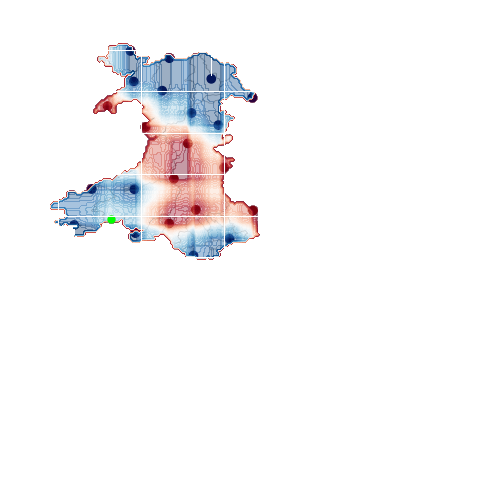

iteration  1
Accuracy is 0.5137473562776389
sim_anneal_isolated coord: (3.8322227413919574, 7.795098366305291) distance: [[33.69276847]]
iteration  2
Accuracy is 0.7767736973658912
sim_anneal_isolated coord: (32.5655920861059, 0.4465220729777757) distance: [[27.03233528]]
iteration  3
Accuracy is 0.710248029225149
sim_anneal_isolated coord: (11.867842720232414, 36.44278621071609) distance: [[21.32558526]]
iteration  4
Accuracy is 0.6614112670640262
sim_anneal_isolated coord: (46.90090739407702, 11.265884785370183) distance: [[17.95995196]]
iteration  5
Accuracy is 0.665833493558931
sim_anneal_isolated coord: (18.318555467569887, 16.406027380033596) distance: [[16.85235694]]
iteration  6
Accuracy is 0.6962122668717554
sim_anneal_isolated coord: (17.384120744299036, 49.716690884730035) distance: [[14.37448672]]
iteration  7
Accuracy is 0.733320515285522
sim_anneal_isolated coord: (33.1312899681044, 11.469423616555002) distance: [[11.03740787]]
iteration  8
Accuracy is 0.7283214766391078


<IPython.core.display.Javascript object>


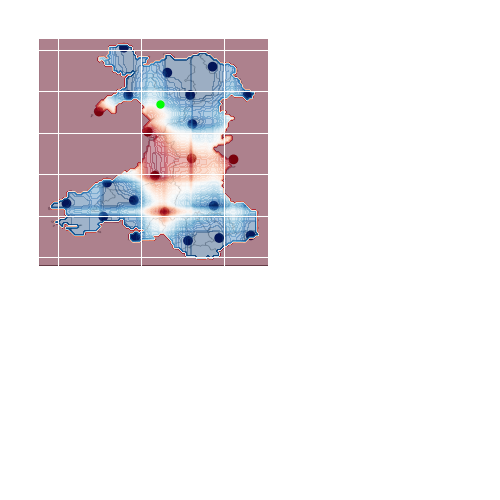

iteration  1
Accuracy is 0.43453182080369157
sim_anneal_isolated coord: (16.848580276049894, 39.08803176303588) distance: [[20.45944727]]
iteration  2
Accuracy is 0.7890790232647568
sim_anneal_isolated coord: (45.601296266262274, 39.14120659897107) distance: [[27.92098285]]
iteration  3
Accuracy is 0.7523553162853297
sim_anneal_isolated coord: (1.9877044192358486, 12.97511710689006) distance: [[22.32171787]]
iteration  4
Accuracy is 0.7694674101134398
sim_anneal_isolated coord: (32.28672457131154, 32.1037070660177) distance: [[15.06002055]]
iteration  5
Accuracy is 0.6940972889828879
sim_anneal_isolated coord: (18.641841962512864, 4.91989779613365) distance: [[15.45981627]]
iteration  6
Accuracy is 0.7081330513362815
sim_anneal_isolated coord: (46.35470969522446, 5.2934487073098175) distance: [[11.4407151]]
iteration  7
Accuracy is 0.7160161507402423
sim_anneal_isolated coord: (37.163450127153254, 45.93663150733837) distance: [[10.83397652]]
iteration  8
Accuracy is 0.7117861949625072


<IPython.core.display.Javascript object>


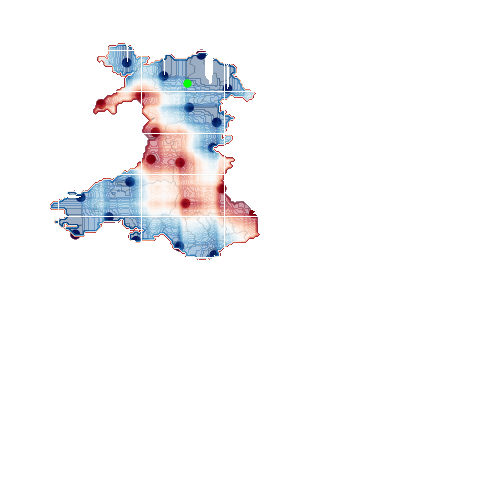

iteration  1
Accuracy is 0.576043068640646
sim_anneal_isolated coord: (5.40218232409641, 14.473528051403639) distance: [[25.27716774]]
iteration  2
Accuracy is 0.5668140742164969
sim_anneal_isolated coord: (40.747051675134195, 40.63109992082858) distance: [[25.04644477]]
iteration  3
Accuracy is 0.6033455104787541
sim_anneal_isolated coord: (23.452811076140186, 30.149332771436022) distance: [[18.12800577]]
iteration  4
Accuracy is 0.7471640069217458
sim_anneal_isolated coord: (47.12042267100003, 10.536563608573084) distance: [[16.66711462]]
iteration  5
Accuracy is 0.7402422611036339
sim_anneal_isolated coord: (18.764179840967977, 4.010196382405207) distance: [[14.89178718]]
iteration  6
Accuracy is 0.8027302441838108
sim_anneal_isolated coord: (17.29615100940328, 18.19317045855628) distance: [[12.46203156]]
iteration  7
Accuracy is 0.762353393578158
sim_anneal_isolated coord: (37.21382024778235, 26.40104937737938) distance: [[14.26236312]]
iteration  8
Accuracy is 0.7587002499519323
s

<IPython.core.display.Javascript object>


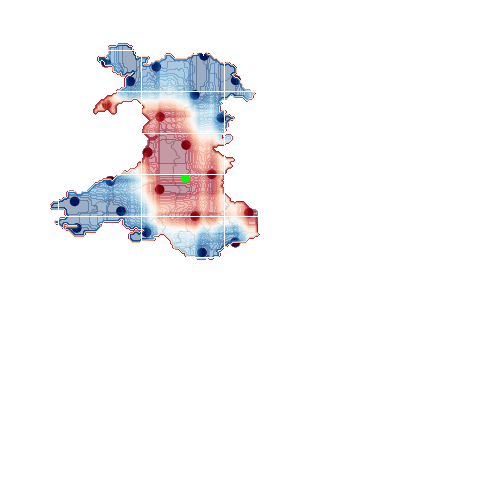

iteration  1
Accuracy is 0.6000769082868679
sim_anneal_isolated coord: (4.444738523876007, 7.0729397759599895) distance: [[22.01208586]]
iteration  2
Accuracy is 0.840992116900596
sim_anneal_isolated coord: (36.97969205944549, 20.027799885890197) distance: [[13.09741041]]
iteration  3
Accuracy is 0.693135935397039
sim_anneal_isolated coord: (34.632528097775776, 1.1561657270824302) distance: [[18.29649903]]
iteration  4
Accuracy is 0.7602384156892905
sim_anneal_isolated coord: (11.533716633150004, 46.97226075825385) distance: [[23.68088927]]
iteration  5
Accuracy is 0.7821572774466449
sim_anneal_isolated coord: (24.529117617386444, 33.836082081989126) distance: [[17.50312575]]
iteration  6
Accuracy is 0.7069794270332629
sim_anneal_isolated coord: (39.29110861800321, 33.59791806560521) distance: [[13.76556406]]
iteration  7
Accuracy is 0.788117669678908
sim_anneal_isolated coord: (45.885905171803266, 10.718491698047714) distance: [[12.88347201]]
iteration  8
Accuracy is 0.786002691790040

<IPython.core.display.Javascript object>


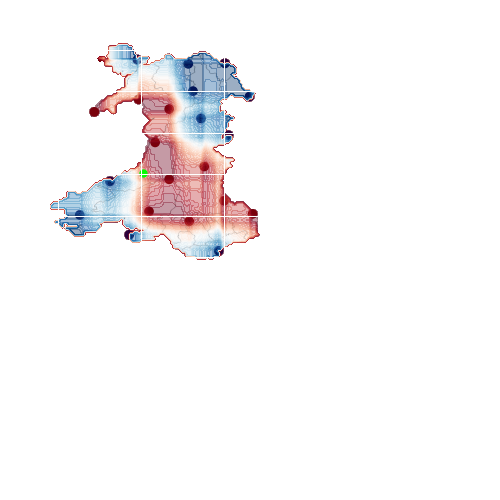

iteration  1
Accuracy is 0.5293212843683907
sim_anneal_isolated coord: (10.161348196527715, 47.58768285623375) distance: [[35.85305348]]
iteration  2
Accuracy is 0.48740626802537973
sim_anneal_isolated coord: (31.31853671547699, 46.61703062846824) distance: [[21.17944267]]
iteration  3
Accuracy is 0.5873870409536628
sim_anneal_isolated coord: (38.653647258275214, 1.5854956863046894) distance: [[20.6015064]]
iteration  4
Accuracy is 0.6544895212459142
sim_anneal_isolated coord: (21.855219098295237, 11.08159552757624) distance: [[16.69553312]]
iteration  5
Accuracy is 0.7040953662757162
sim_anneal_isolated coord: (23.330057399695175, 27.690591642311432) distance: [[13.17746406]]
iteration  6
Accuracy is 0.6604499134781773
sim_anneal_isolated coord: (46.05350976539863, 38.742876555088266) distance: [[16.70693668]]
iteration  7
Accuracy is 0.6867910017304365
sim_anneal_isolated coord: (19.353593731837684, 38.07635710667896) distance: [[11.12098861]]
iteration  8
Accuracy is 0.6471832339934

<IPython.core.display.Javascript object>


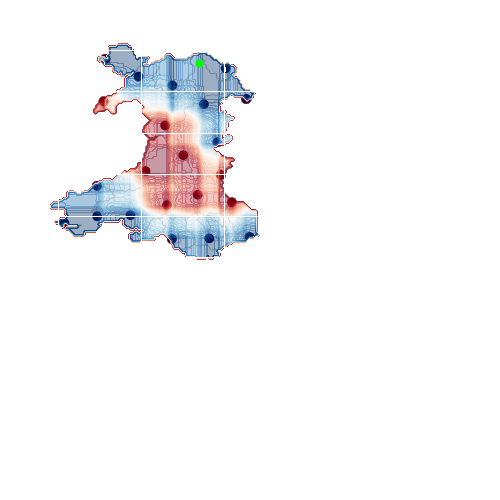

iteration  1
Accuracy is 0.5195154777927322
sim_anneal_isolated coord: (46.12007643303772, 4.932713463358299) distance: [[29.68281918]]
iteration  2
Accuracy is 0.7363968467602384
sim_anneal_isolated coord: (40.328353344356934, 45.530184682058774) distance: [[21.09773089]]
iteration  3
Accuracy is 0.644491443953086
sim_anneal_isolated coord: (1.5207010625161175, 8.22459115034946) distance: [[23.19079726]]
iteration  4
Accuracy is 0.8144587579311671
sim_anneal_isolated coord: (27.393923265906007, 4.458525932783903) distance: [[17.51976949]]
iteration  5
Accuracy is 0.7150547971543934
sim_anneal_isolated coord: (38.32605666998151, 27.760639502573774) distance: [[17.88200011]]
iteration  6
Accuracy is 0.6890982503364738
sim_anneal_isolated coord: (33.579655274699974, 15.092440132373273) distance: [[12.30217102]]
iteration  7
Accuracy is 0.7638915593155162
sim_anneal_isolated coord: (25.72934485426728, 31.778412687916262) distance: [[11.96620116]]
iteration  8
Accuracy is 0.787156316093059

<IPython.core.display.Javascript object>


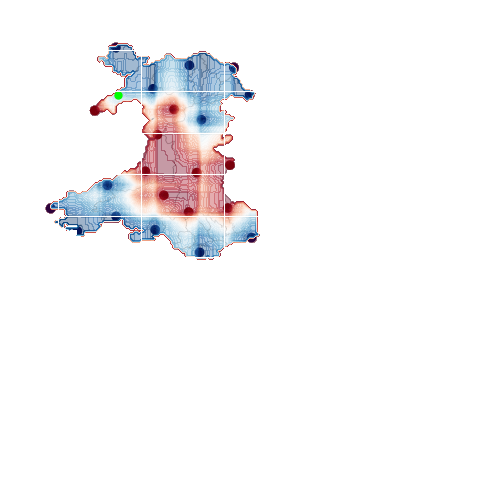

iteration  1
Accuracy is 0.4943280138434916
sim_anneal_isolated coord: (22.818696406345886, 40.5894163389469) distance: [[33.87774586]]
iteration  2
Accuracy is 0.6062295712363007
sim_anneal_isolated coord: (42.29345502585191, 45.70821572347202) distance: [[20.1362442]]
iteration  3
Accuracy is 0.6508363776196885
sim_anneal_isolated coord: (20.99019524570101, 20.724229386865947) distance: [[19.94916212]]
iteration  4
Accuracy is 0.6764083830032686
sim_anneal_isolated coord: (23.341219465165317, 6.669010067503251) distance: [[14.25049139]]
iteration  5
Accuracy is 0.6846760238415689
sim_anneal_isolated coord: (34.480251319367625, 33.15565844843996) distance: [[13.82941139]]
iteration  6
Accuracy is 0.636800615266295
sim_anneal_isolated coord: (33.353206621846326, 20.41840674053176) distance: [[11.33483552]]
iteration  7
Accuracy is 0.7275523937704288
sim_anneal_isolated coord: (8.810924716828094, 35.353005939750716) distance: [[14.95451977]]
iteration  8
Accuracy is 0.7287060180734474
s

<IPython.core.display.Javascript object>


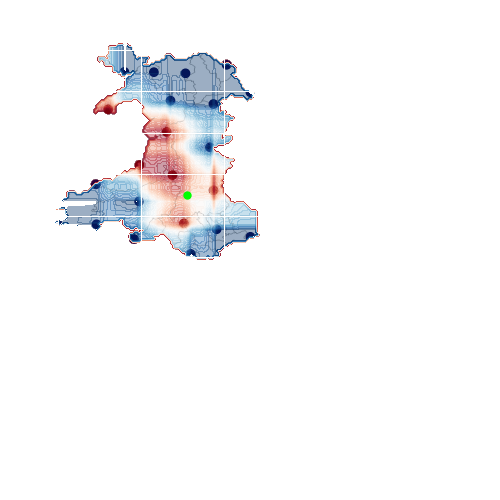

iteration  1
Accuracy is 0.5006729475100942
sim_anneal_isolated coord: (-0.3087832961832091, 8.55029374231178) distance: [[34.1713805]]
iteration  2
Accuracy is 0.6191117092866757
sim_anneal_isolated coord: (31.909208835893104, 0.835369887873556) distance: [[29.95338015]]
iteration  3
Accuracy is 0.6846760238415689
sim_anneal_isolated coord: (46.28608192346939, 39.76261402896753) distance: [[22.31700151]]
iteration  4
Accuracy is 0.7346664103057104
sim_anneal_isolated coord: (19.473949421854655, 13.477785803314518) distance: [[17.73319928]]
iteration  5
Accuracy is 0.6894827917708133
sim_anneal_isolated coord: (37.38558347219861, 16.162303109154102) distance: [[16.27591967]]
iteration  6
Accuracy is 0.7365891174774082
sim_anneal_isolated coord: (36.5414760860996, 26.521216150506554) distance: [[10.39324765]]
iteration  7
Accuracy is 0.7565852720630648
sim_anneal_isolated coord: (46.286946841425646, 4.950976931621608) distance: [[14.31531014]]
iteration  8
Accuracy is 0.7292828302249568

<IPython.core.display.Javascript object>


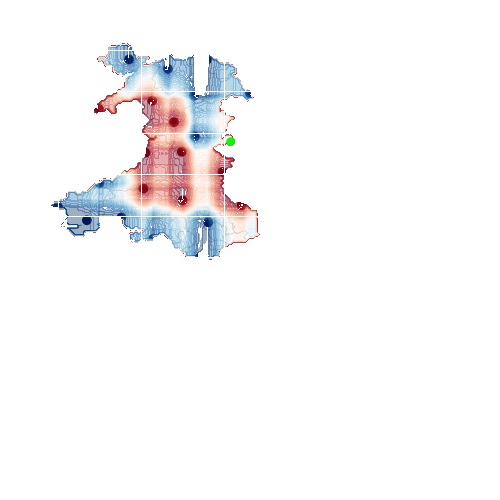

iteration  1
Accuracy is 0.5670063449336666
sim_anneal_isolated coord: (34.13357089616777, -0.016235527805633865) distance: [[28.4418729]]
iteration  2
Accuracy is 0.5156700634493366
sim_anneal_isolated coord: (17.05206680798375, 47.68038893360856) distance: [[22.8060385]]
iteration  3
Accuracy is 0.6802537973466641
sim_anneal_isolated coord: (15.206296830466348, 9.614089052315059) distance: [[16.65578864]]
iteration  4
Accuracy is 0.7125552778311863
sim_anneal_isolated coord: (35.77618069931765, 47.57697639597174) distance: [[18.68867087]]
iteration  5
Accuracy is 0.7117861949625072
sim_anneal_isolated coord: (-0.0936919714657467, 12.223892120886674) distance: [[15.52097708]]
iteration  6
Accuracy is 0.6908286867910017
sim_anneal_isolated coord: (44.14855784909683, 12.52544112281656) distance: [[16.04972326]]
iteration  7
Accuracy is 0.7352432224572197
sim_anneal_isolated coord: (9.811249404764162, 35.77010986783925) distance: [[13.93858616]]
iteration  8
Accuracy is 0.761776581426648

<IPython.core.display.Javascript object>


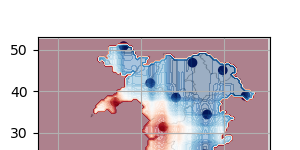

iteration  1
Accuracy is 0.5920015381657373
sim_anneal_isolated coord: (39.67693108043588, 2.6828926630233685) distance: [[43.41542586]]
iteration  2
Accuracy is 0.5089405883483945
sim_anneal_isolated coord: (3.789886378000617, 6.000253939714074) distance: [[32.95888052]]
iteration  3
Accuracy is 0.6006537204383773
sim_anneal_isolated coord: (35.206667407357806, 24.84622194961967) distance: [[22.22915294]]
iteration  4
Accuracy is 0.5758507979234763
sim_anneal_isolated coord: (22.101020776281363, 10.159915210070045) distance: [[18.7776576]]
iteration  5
Accuracy is 0.6210344164583734
sim_anneal_isolated coord: (45.123717135053525, 38.87850843721541) distance: [[15.09172462]]
iteration  6
Accuracy is 0.6391078638723322
sim_anneal_isolated coord: (25.306228959230875, 31.450160054438513) distance: [[11.90086887]]
iteration  7
Accuracy is 0.6429532782157278
sim_anneal_isolated coord: (10.808646561640991, 18.121073937109927) distance: [[13.81657569]]
iteration  8
Accuracy is 0.6752547587002

<IPython.core.display.Javascript object>


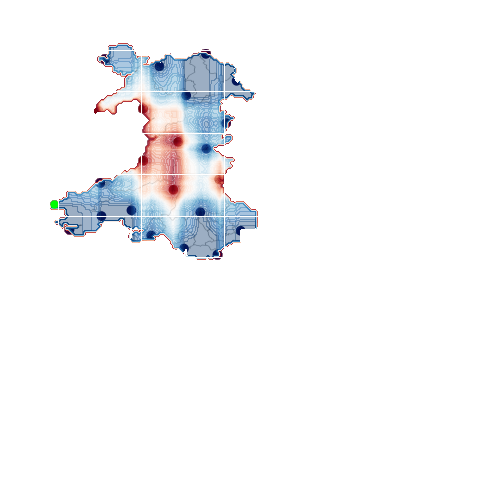

iteration  1
Accuracy is 0.37319746202653337
sim_anneal_isolated coord: (42.96059989479016, 42.52896020522198) distance: [[34.0468157]]
iteration  2
Accuracy is 0.585464333781965
sim_anneal_isolated coord: (43.91295047974127, 6.414141195389582) distance: [[26.74300665]]
iteration  3
Accuracy is 0.6431455489328975
sim_anneal_isolated coord: (28.891720672804894, 27.8104925602537) distance: [[19.96014356]]
iteration  4
Accuracy is 0.6754470294174197
sim_anneal_isolated coord: (24.370855044677263, 46.0176995367173) distance: [[18.2090343]]
iteration  5
Accuracy is 0.6860219188617573
sim_anneal_isolated coord: (30.27830365013657, 2.1189656776447556) distance: [[14.29517845]]
iteration  6
Accuracy is 0.6927513939626995
sim_anneal_isolated coord: (2.713691363377304, 6.697755518401388) distance: [[15.61644523]]
iteration  7
Accuracy is 0.7046721784272255
sim_anneal_isolated coord: (38.75114807153279, 18.80586980521108) distance: [[13.3525855]]
iteration  8
Accuracy is 0.7094789463564699
sim_an

<IPython.core.display.Javascript object>


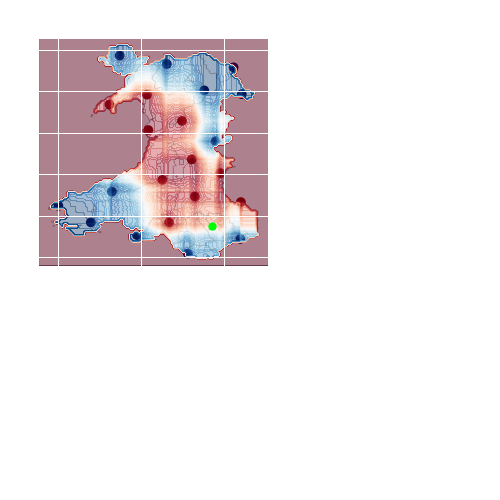

iteration  1
Accuracy is 0.646221880407614
sim_anneal_isolated coord: (0.03990421123666188, 12.395711011421033) distance: [[32.93746805]]
iteration  2
Accuracy is 0.8027302441838108
sim_anneal_isolated coord: (14.792986167447602, 48.60986656801937) distance: [[22.02802136]]
iteration  3
Accuracy is 0.7860026917900403
sim_anneal_isolated coord: (18.96269552570989, 5.372086332958502) distance: [[16.75140444]]
iteration  4
Accuracy is 0.7494712555277832
sim_anneal_isolated coord: (21.69505738916205, 30.67197382178176) distance: [[16.50925388]]
iteration  5
Accuracy is 0.8429148240722938
sim_anneal_isolated coord: (12.919305349426761, 15.822470594438956) distance: [[12.07199636]]
iteration  6
Accuracy is 0.8390694097288983
sim_anneal_isolated coord: (43.86884828271229, 4.448819818108873) distance: [[14.99140346]]
iteration  7
Accuracy is 0.8075370121130552
sim_anneal_isolated coord: (37.91394883848821, 27.967621557665684) distance: [[12.55987841]]
iteration  8
Accuracy is 0.845606614112670

<IPython.core.display.Javascript object>


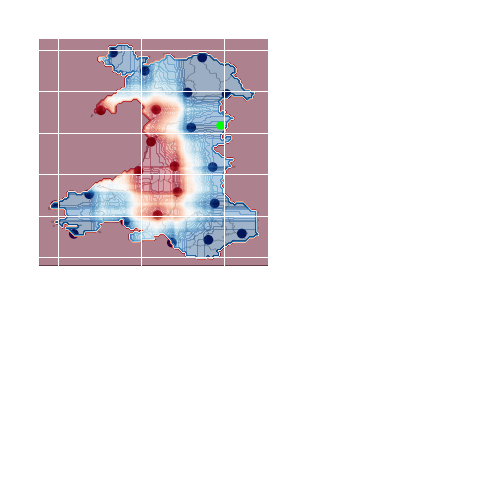

iteration  1
Accuracy is 0.533358969428956
sim_anneal_isolated coord: (34.6660890959836, 48.139223449095454) distance: [[31.36960163]]
iteration  2
Accuracy is 0.7638915593155162
sim_anneal_isolated coord: (44.214638328062335, 5.741679110078169) distance: [[29.08034328]]
iteration  3
Accuracy is 0.7500480676792924
sim_anneal_isolated coord: (13.163364971151175, 49.300473046923976) distance: [[21.5340578]]
iteration  4
Accuracy is 0.7490867140934435
sim_anneal_isolated coord: (37.19973160833678, 21.74976452530994) distance: [[17.47763471]]
iteration  5
Accuracy is 0.6781388194577965
sim_anneal_isolated coord: (27.358255284254238, 3.5630652306374575) distance: [[16.99658812]]
iteration  6
Accuracy is 0.6460296096904441
sim_anneal_isolated coord: (23.589320462465388, 35.6192836860488) distance: [[15.4424667]]
iteration  7
Accuracy is 0.6894827917708133
sim_anneal_isolated coord: (40.54521682293905, 39.33142795179969) distance: [[10.58968386]]
iteration  8
Accuracy is 0.6887137089021342
si

<IPython.core.display.Javascript object>


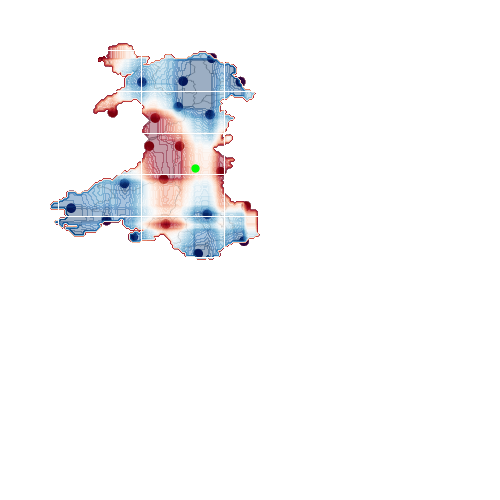

iteration  1
Accuracy is 0.4962507210151894
sim_anneal_isolated coord: (44.71576383681747, 3.9281993147502265) distance: [[41.20653696]]
iteration  2
Accuracy is 0.5779657758123438
sim_anneal_isolated coord: (25.88017304282843, 8.0131810603184) distance: [[19.27346768]]
iteration  3
Accuracy is 0.5779657758123438
sim_anneal_isolated coord: (3.1008656356864055, 11.856819826896533) distance: [[23.10130743]]
iteration  4
Accuracy is 0.5837338973274371
sim_anneal_isolated coord: (29.218133837345693, 26.803633943898745) distance: [[15.66402827]]
iteration  5
Accuracy is 0.6754470294174197
sim_anneal_isolated coord: (13.125619294012413, 34.93771264644961) distance: [[13.37020364]]
iteration  6
Accuracy is 0.6477600461449721
sim_anneal_isolated coord: (43.85712831877091, 42.276895392517204) distance: [[13.78743907]]
iteration  7
Accuracy is 0.6748702172659105
sim_anneal_isolated coord: (15.929583741486804, 17.79274072307316) distance: [[13.95184628]]
iteration  8
Accuracy is 0.698134974043453

<IPython.core.display.Javascript object>


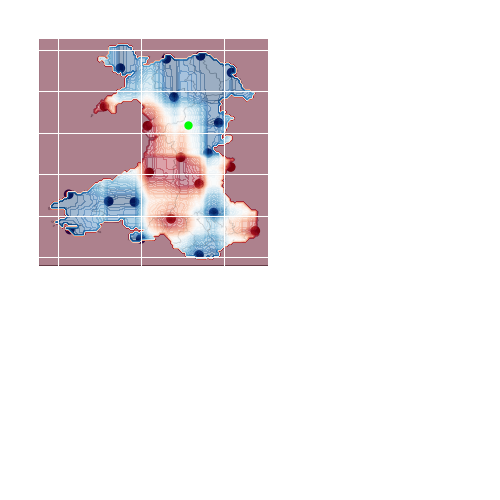

iteration  1
Accuracy is 0.4781772736012305
sim_anneal_isolated coord: (14.948670867185362, 45.56746240198859) distance: [[25.92803929]]
iteration  2
Accuracy is 0.7225533551240146
sim_anneal_isolated coord: (2.8018032973086218, 6.703787297081037) distance: [[31.87598355]]
iteration  3
Accuracy is 0.7262064987502403
sim_anneal_isolated coord: (41.7512868090702, 44.51054204972042) distance: [[23.79300527]]
iteration  4
Accuracy is 0.7394731782349548
sim_anneal_isolated coord: (12.141125741325185, 13.518026022283916) distance: [[11.56100312]]
iteration  5
Accuracy is 0.7423572389925014
sim_anneal_isolated coord: (18.3636153564669, 13.332914101130385) distance: [[6.22524244]]
iteration  6
Accuracy is 0.7069794270332629
sim_anneal_isolated coord: (27.861943203859077, 38.59603579751233) distance: [[14.57782074]]
iteration  7
Accuracy is 0.6867910017304365
sim_anneal_isolated coord: (33.88514194246007, 0.5824001940406749) distance: [[10.79217146]]
iteration  8
Accuracy is 0.6814074216496827


<IPython.core.display.Javascript object>


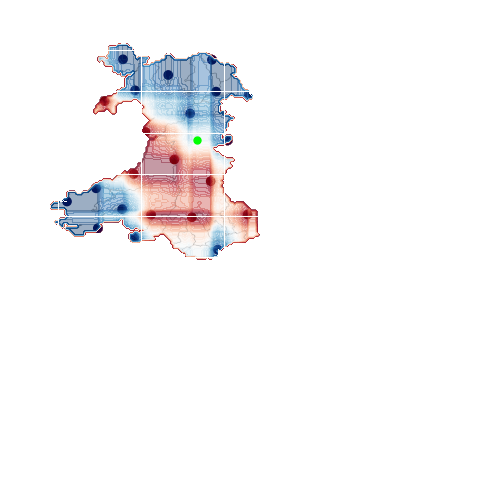

iteration  1
Accuracy is 0.6079600076908287
sim_anneal_isolated coord: (38.42187710798808, 1.8703248580238672) distance: [[33.26632397]]
iteration  2
Accuracy is 0.525668140742165
sim_anneal_isolated coord: (2.0998465861743423, 13.45775144483917) distance: [[25.2789898]]
iteration  3
Accuracy is 0.6781388194577965
sim_anneal_isolated coord: (22.344439941853835, 10.288962337532539) distance: [[18.1482077]]
iteration  4
Accuracy is 0.6664103057104404
sim_anneal_isolated coord: (15.58803846075535, 47.69907942083058) distance: [[18.30161126]]
iteration  5
Accuracy is 0.7369736589117477
sim_anneal_isolated coord: (36.71522427519184, 18.34283118421915) distance: [[16.47374413]]
iteration  6
Accuracy is 0.7704287636992886
sim_anneal_isolated coord: (45.83461660543588, 39.18519333575146) distance: [[14.77483851]]
iteration  7
Accuracy is 0.7692751393962699
sim_anneal_isolated coord: (11.184419754058936, 37.65180651843928) distance: [[10.96993849]]
iteration  8
Accuracy is 0.7352432224572197
si

<IPython.core.display.Javascript object>


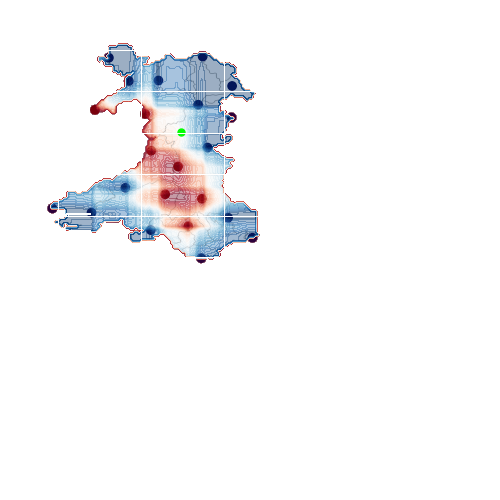

iteration  1
Accuracy is 0.4922130359546241
sim_anneal_isolated coord: (24.126898271776156, 42.5970416261201) distance: [[30.34879714]]
iteration  2
Accuracy is 0.6137281292059219
sim_anneal_isolated coord: (41.87342733907737, 41.28370987945342) distance: [[17.79505926]]
iteration  3
Accuracy is 0.6881368967506248
sim_anneal_isolated coord: (8.849723566341506, 35.540109309748246) distance: [[16.8283202]]
iteration  4
Accuracy is 0.6977504326091136
sim_anneal_isolated coord: (22.400913076667408, 25.68406496632879) distance: [[16.75638228]]
iteration  5
Accuracy is 0.6960199961545857
sim_anneal_isolated coord: (22.294365362668774, 6.568289547618328) distance: [[14.42994628]]
iteration  6
Accuracy is 0.7152470678715631
sim_anneal_isolated coord: (34.455340605504794, -0.19130925273388816) distance: [[13.9133567]]
iteration  7
Accuracy is 0.7550471063257066
sim_anneal_isolated coord: (12.190784673720414, 48.080198444782454) distance: [[12.97753924]]
iteration  8
Accuracy is 0.78984810613343

In [8]:
from random import randint
import time

valid_seeds = [4,27,12,15,17,21,23,24,25,28,31,32,35,36,37,41,42,43,45,48,420]

Results = []

for j in range(len(valid_seeds)):
    
    random.seed(valid_seeds[j])

    print('experiment: ',j)                            

    num = 100
    x = np.linspace(-5, 51, num)
    y = np.linspace(-2, 53, num)
    global landpoints 
    landpoints = []

    for i in range(num):
        for j in range(num):
            if wales.contains_points([(x[i],y[j])]):
                landpoints.append([x[i],y[j]])

    landpoints = np.asarray(landpoints, dtype=np.float32)

    i=0 
    coords = []

    for i in range(numcoords):
        value = randint(0, landpoints.size/2)
        coords.append((landpoints[value][0],
                            landpoints[value][1],
                            braninColor(landpoints[value],threshold)))
        i+=1

    global fig1,ax
    fig1, ax = plt.subplots(figsize = (3,3))
    ax.set_xlim(-5,51)
    ax.set_ylim(-2,53)
    img = plt.imread('WalesMap.png');
    ax.imshow(img, extent=[-5, 51, -2, 53])
    ax.scatter([x[0] for x in coords],[y[1] for y in coords], c= [z[2] for z in coords], cmap = 'seismic')
    # plt.axis("off")
    plt.grid()
    # cid = fig1.canvas.mpl_connect('button_press_event', Helicopter)

    fig1.show()
    fig1.canvas.draw()

    global accuracyArray
    accuracyArray = []

    for i in range(maxiter):
        plt.pause(1)
        print('iteration ',i+1)
    #     print('Calculating Model... ')
        calculateModel()
        plt.pause(1)
        fig1.canvas.draw()    
        Accuracy()
    #     print('Finding Isolated Point')
        if(i!=maxiter):
                     #0 for 0.5, 1 for isolated, 2 for random

            if(selection_model == 0):    
                nextpoint = find0_5()
            elif(selection_model==1):
                nextpoint=find_isolated_point()
            elif(selection_model==2):
                nextpoint = random_point()
            elif(selection_model==3):
                nextpoint = best()
            elif(selection_model==4):
                nextpoint = sim_anneal_iso()
            plt.pause(1)
            fig1.canvas.draw()
            coords.append((nextpoint[0], nextpoint[1], braninColor(nextpoint,threshold)))  
            plt.pause(1)
            fig1.canvas.draw()

    plt.close()
    
    Results.append(accuracyArray)
    
    

In [9]:
print('Highest Accuracy =',"{:.2f}".format((max(accuracyArray)*100)),'%')
print('Improvement is =', "{:.2f}".format((max(accuracyArray)-accuracyArray[0])*100),'%')

Highest Accuracy = 86.52 %
Improvement is = 37.30 %


In [10]:
np.savetxt('braninIsolatedSimAnneal', Results)